Belirlenmiş veri seti kullanılarak sentetik insan yüzleri üretimi sağlayan, derin öğrenme teknolojilerinden olan GAN teknolojisi ile gerçekleştirilmiş bir projedir. Pytorch kullanılmıştır. -Nazlı Sıla Özakca

In [1]:
#tensorflow versiyonu yazsa da pytorch ile gerçekleştirilen bir projedir.
from google.colab import drive
%tensorflow_version 2.x
drive.mount('/content/drive', force_remount=True)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Mounted at /content/drive


In [2]:
!git clone https://github.com/NVlabs/stylegan3.git
!pip install ninja
#pytorch'un alt kütüphanelerinden olan ninja eklenir.

Cloning into 'stylegan3'...
remote: Enumerating objects: 207, done.
remote: Total 207 (delta 0), reused 0 (delta 0), pack-reused 207
Receiving objects: 100% (207/207), 4.16 MiB | 23.04 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 9.0 MB/s eta 0:00:00


In [4]:
#içeriğe göz atıyorum
!ls /content/stylegan3

avg_spectra.py	 Dockerfile	  gen_video.py	metrics      train.py
calc_metrics.py  docs		  gui_utils	README.md    visualizer.py
dataset_tool.py  environment.yml  legacy.py	torch_utils  viz
dnnlib		 gen_images.py	  LICENSE.txt	training


In [5]:
#26 resmin belirlnenen 6600 seed ile çalıştırılması
!python /content/stylegan3/gen_images.py \
    --network=https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl \
  --outdir=/content/results --seeds=6600-6625 

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...
Generating image for seed 6600 (0/26) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
Generating image for seed 6601 (1/26) ...
Generating image for seed 6602 (2/26) ...
Generating image for seed 6603 (3/26) ...
Generating image for seed 6604 (4/26) ...
Generating image for seed 6605 (5/26) ...
Generating image for seed 6606 (6/26) ...
Generating image for seed 6607 (7/26) ...
Generating image for seed 6608 (8/26) ...
Generating image for seed 6609 (9/26) ...
Generating image for seed 6610 (10/26) ...
Generating image for seed 6611 (11/26) ...
Generating image for seed 6612 (12/26) ...
Generating image for seed 6613 (13/26) ...
Generating image for seed 6614 (14/26) ...
Generating image for seed 6615 (15/26) ...
Generating image for seed 6616 (16/26) ...
Generating image for seed 661

In [6]:
!ls /content/results/

seed6600.png  seed6606.png  seed6612.png  seed6618.png	seed6624.png
seed6601.png  seed6607.png  seed6613.png  seed6619.png	seed6625.png
seed6602.png  seed6608.png  seed6614.png  seed6620.png
seed6603.png  seed6609.png  seed6615.png  seed6621.png
seed6604.png  seed6610.png  seed6616.png  seed6622.png
seed6605.png  seed6611.png  seed6617.png  seed6623.png


In [8]:
#bu aşamada driveınıza bir klasör ekleyin, benim yolum aşağıda yer alıyor. kendi yolunuza göre ekleyin. bu komutlar klasörlerin oluşmasını sağlayacaktır.
!cp /content/results/* \
    /content/drive/My\ Drive/goruntuislemeprojeler/stylegan3

In [10]:
import sys
sys.path.insert(0, "/content/stylegan3")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy

def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi):
    # Rastgele seedkerle başlatılan dlatentler için görüntüleri işliyorum.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    images = G.run(z, label, **G_kwargs) # [minibatch, height, width, channel]
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail('Koşullu bir ağ kullanırken --class ile sınıf etiketi belirtilmelidir')
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ('uyarı: --class=lbl, koşulsuz bir ağda çalışırken yok sayılır')
  return label

def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const', class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  #PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.png')
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')


In [11]:

#URL = "https://github.com/jeffheaton/pretrained-gan-fish/releases/download/1.0.0/fish-gan-2020-12-09.pkl"
#URL = "https://github.com/jeffheaton/pretrained-merry-gan-mas/releases/download/v1/christmas-gan-2020-12-03.pkl"
URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...


Seed(Tohum) 1010


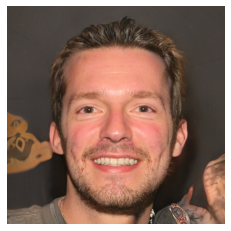

Seed(Tohum) 1011


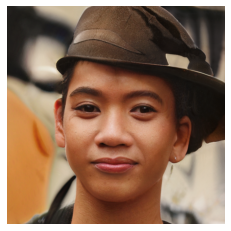

Seed(Tohum) 1012


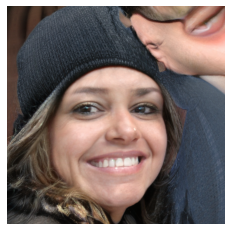

Seed(Tohum) 1013


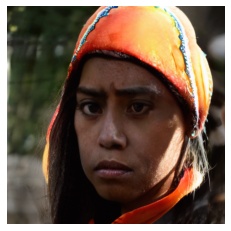

Seed(Tohum) 1014


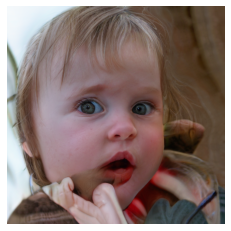

Seed(Tohum) 1015


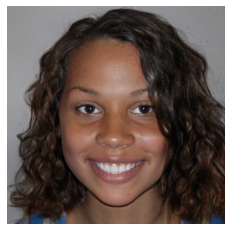

Seed(Tohum) 1016


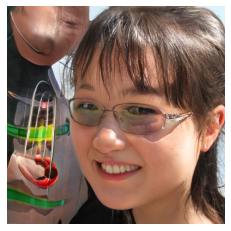

Seed(Tohum) 1017


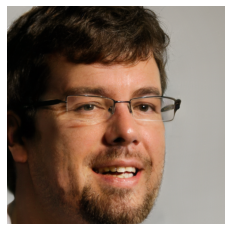

Seed(Tohum) 1018


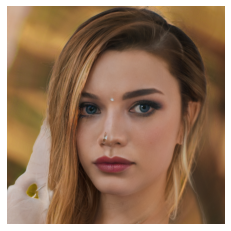

Seed(Tohum) 1019


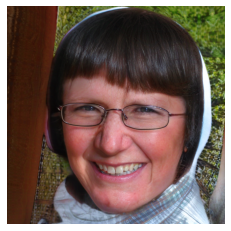

In [15]:
# Kendi başlangıç ​​ve bitiş seedimizi seçiyorum. aralık belirledim
SEED_FROM = 1010
SEED_TO = 1020

# Seedler için görüntüleri oluşturuluyor
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed(Tohum) {i}")
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  display_image(img)

Yukarıda oluşturulan path'te diğer görüntüler de gözükmektedir.